Plotting Temporal data from: /share/home/dynamo2/wangyu/scripts/work6/manuscripts/archive/data/Taylor_temporal.csv
Plotting Spatial data from: /share/home/dynamo2/wangyu/scripts/work6/manuscripts/archive/data/Taylor_spatial.csv


/tmp/ipykernel_17047/3636879342.py:31: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. To prevent this warning, set `apply_theta_transforms=False`, and make sure to shift theta values before being passed to this transform.
  tr = PolarAxes.PolarTransform()
/tmp/ipykernel_17047/3636879342.py:167: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. To prevent this warning, set `apply_theta_transforms=False`, and make sure to shift theta values before being passed to this transform.
  plt.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
/tmp/ipykernel_17047/3636879342.py:31: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.

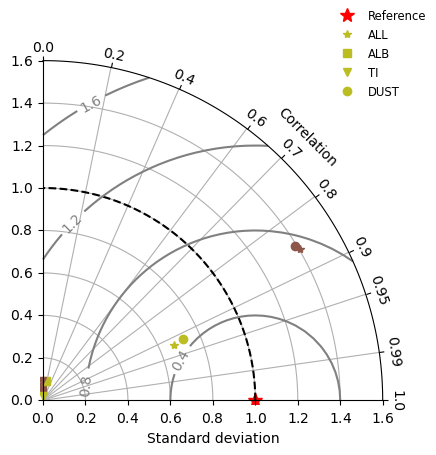

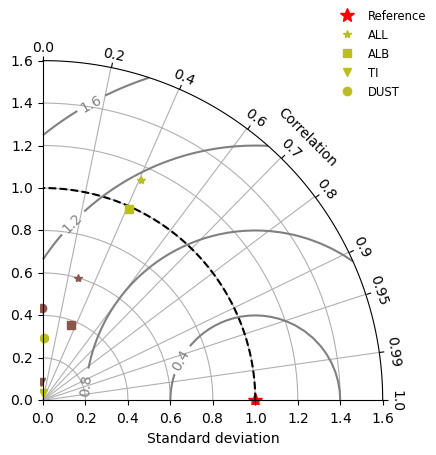

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF

class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd, fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = np.pi
            rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = np.pi/2
        
        tlocs = np.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = plt.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = np.linspace(0, self.tmax)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """
        l, = self.ax.plot(np.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)
        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""
        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),
                             np.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)
        return contours
    
    def finalize(self):
        self.ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        self.ax.set_title("Taylor Diagram")


def generate_taylor_plot(df_data):
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    Args:
        df_data: pandas DataFrame containing the data to plot
    """

    # Reference std
    stdref = 1

    # Extract samples using the exact logic from original code
    samples = [
        df_data.loc[0, ['v_3', 'r_3', 'run']].values,
        df_data.loc[0, ['v_15', 'r_15', 'run']].values,
        df_data.loc[1, ['v_3', 'r_3', 'run']].values,
        df_data.loc[1, ['v_15', 'r_15', 'run']].values,
        df_data.loc[2, ['v_3', 'r_3', 'run']].values,
        df_data.loc[2, ['v_15', 'r_15', 'run']].values,
        df_data.loc[3, ['v_3', 'r_3', 'run']].values,
        df_data.loc[3, ['v_15', 'r_15', 'run']].values,              
    ]
    
    colors = ['tab:brown', 'tab:olive',] * 4
    marker = ['*', '*', 's', 's', 'v', 'v', 'o', 'o']
    
    fig = plt.figure(figsize=(4.5, 4.5))

    dia = TaylorDiagram(stdref, fig=fig, label='Reference', srange=(0, 1.6))
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker=marker[i],
                       color=colors[i],
                       linestyle='None',
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.1f')

    dia.add_grid()                                      # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)      # Put ticks outward

    # Add a figure legend and title
    fig.legend(dia.samplePoints[::2],
               [p.get_label() for p in dia.samplePoints[::2]],
               numpoints=1, loc='upper right', frameon=False,
               prop=dict(size='small'))
    
    return dia, fig

if __name__ == "__main__":
    # Define file paths
    temporal_path = '../data/Taylor_temporal.csv'
    spatial_path = '../data/Taylor_spatial.csv'

    # Plot 1: Temporal
    print(f"Plotting Temporal data from: {temporal_path}")
    df_temporal = pd.read_csv(temporal_path)
    dia_temporal, fig_temporal = generate_taylor_plot(df_temporal)

    # Plot 2: Spatial
    print(f"Plotting Spatial data from: {spatial_path}")
    df_spatial = pd.read_csv(spatial_path)
    dia_spatial, fig_spatial = generate_taylor_plot(df_spatial)
